### Load data and predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
def show_result(X_test, y_pred, idx, show_image=False):
    labels = ['Clear Sky', 'Patterned Clouds', 'Thick Dark Clouds',
       'Thick White Clouds', 'Veil Clouds']

    if show_image:
        plt.imshow(X_test[idx])
        plt.show()
    
    print("The classifier says that the image shown is from class -> {}".format(labels[np.argmax(y_pred[idx])]))
    
    return labels[np.argmax(y_pred[idx])]

In [3]:
from DataLoader import DataLoader

data = DataLoader()
data.load_data("/Users/marcosplazagonzalez/Desktop/Ground-based_CloudClassification/Datasets/swimcat_TrainTest/test/", 256, 3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.59it/s]


In [4]:
from keras.models import load_model
model = load_model('./Models/Test4_swimcat_TrainTest_1e-3_PreImagenet_noAug.h5')

2022-06-29 08:54:35.952047: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-29 08:54:35.952161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         327936    
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 4,683,845
Trainable params: 2,425,861
Non-trainable params: 2,257,984
______________________________________

In [6]:
y_pred = model.predict(data.X)

2022-06-29 08:54:37.164797: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-29 08:54:37.165009: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-29 08:54:37.292775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [7]:
y_pred.shape

(238, 5)

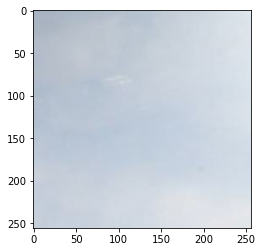

The classifier says that the image shown is from class -> Veil Clouds


'Veil Clouds'

In [8]:
show_result(data.X, y_pred, 190, show_image=True)

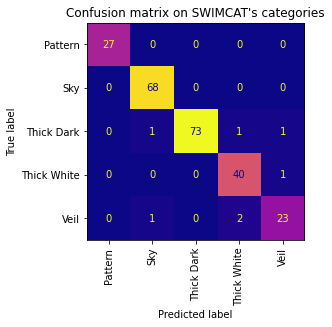

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from IPython.display import display, HTML

matrix = confusion_matrix(data.y.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data.class_names)
disp.plot(colorbar=False, cmap='plasma', xticks_rotation='vertical')
plt.title("Confusion matrix on SWIMCAT's categories")
plt.show()

In [10]:
report = classification_report(data.y.argmax(axis=1), y_pred.argmax(axis=1), target_names=data.class_names)
print(report) 

              precision    recall  f1-score   support

     Pattern       1.00      1.00      1.00        27
         Sky       0.97      1.00      0.99        68
  Thick Dark       1.00      0.96      0.98        76
 Thick White       0.93      0.98      0.95        41
        Veil       0.92      0.88      0.90        26

    accuracy                           0.97       238
   macro avg       0.96      0.96      0.96       238
weighted avg       0.97      0.97      0.97       238



### Conformal Prediction

In [11]:
p_max = np.array([y_pred[i,v] for i,v in enumerate(data.y.argmax(axis=1))]) 
conformal_scores = 1. - p_max

alpha = 0.05
n = len(conformal_scores)
q_hat = np.quantile(conformal_scores, (n+1) * (1. - alpha) / n)

In [12]:
names = {0:'Clear Sky', 1:'Patterned Clouds', 2:'Thick Dark Clouds', 3:'Thick White Clouds', 4:'Veil Clouds'}

In [13]:
cont = 0.
N = 10
for i in range(0,N):
    sel = {j:k for j,k in enumerate(y_pred[i]) if k > (1. - q_hat)}
    if data.y[i].argmax() in sel:
        cont += 1.
    if len(sel) < 2:
        continue
    ax = plt.figure(figsize=(3,3))
    plt.imshow(data.X[i])
    print('No selected class' if len(sel) == 0 else {names[j]:sel[j] for j in sel.keys()})
    plt.show()

print("Theoretical Calibration = ",1.-alpha)
print("Emphirical Calibration of "+str(N)+" images = ",cont/N)

Theoretical Calibration =  0.95
Emphirical Calibration of 10 images =  1.0


In [14]:
from tqdm import tqdm
emph_cal = []
N = 20
for alpha in tqdm(np.arange(0.05,1.,0.05)):
    n = len(conformal_scores)
    q_hat = np.quantile(conformal_scores, (n+1) * (1. - alpha) / n)
    cont = 0.
    for i in range(0,N):
        sel = {j:k for j,k in enumerate(y_pred[i]) if k > (1. - q_hat)}
        if data.y[i].argmax() in sel:
            cont += 1.
    emph_cal += [cont]
emph_cal = np.array(emph_cal)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 4034.82it/s]


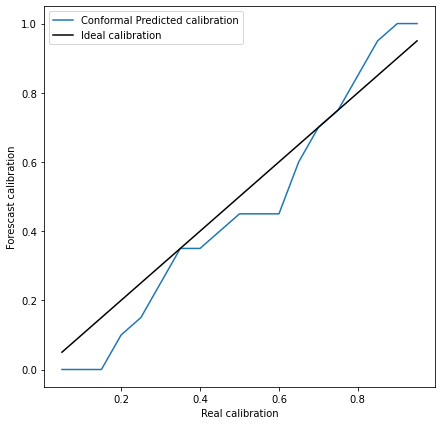

In [15]:
plt.figure(figsize=(7,7))
plt.plot(1-np.arange(0.05,1.,0.05),emph_cal/N,label='Conformal Predicted calibration')
plt.plot(1-np.arange(0.05,1.,0.05),1-np.arange(0.05,1.,0.05),color='black',label='Ideal calibration')
plt.ylabel('Forescast calibration')
plt.xlabel('Real calibration')
plt.legend()
plt.show()